In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import random
import itertools

In [ ]:
class City:
    def __init__(self,no_of_loc,locations=None,edges=None):
    #here locations is a dictionary,{ nodeid: (x, y)} for specific locations
        self.G = nx.Graph()
         #it creates an undirected graph
        # it can have nodes(with positions) and edges
        self.pos = {}
        self.num_nodes = no_of_loc
        if locations:
            self.pos = {k: np.array(v) for k, v in locations.items()}
            #converts to numpy array
        else:
            self.pos = {i: np.array([random.uniform(0, 30), random.uniform(0, 30)]) for i in range(0, no_of_loc)}
        for node, coord in self.pos.items():
            self.G.add_node(node, pos=coord)
        if edges is not None:
            self.build_edges(edges) #adds edges between nodes
        else:
            self.build_edges_random() #builds edges in case they arent provided
        self.edges = list(self.G.edges())
        self.edge_map = {tuple(sorted(e)): i for i, e in enumerate(self.edges)} #assigns key to each edge
        self.num_edges = len(self.edges)
        self.true_alphas = np.random.uniform(-1.0, 1.0, self.num_edges) #randomly generate
        self.learned_alphas = np.zeros(self.num_edges)
        
    def build_edges(self,edges):
        for u, v, dist in edges:
            dist = float(dist)
            self.G.add_edge(u, v, distance=dist, weight=dist) 
        
    def build_edges_random(self):
        nodes = list(self.G.nodes())
        threshold1 = 10.0  
        threshold2 = 15.0

        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                #bcz edge (2,3) is same as edge (3,2)
                u, v = nodes[i], nodes[j]
                d = float(np.linalg.norm(self.pos[u] - self.pos[v]))
                if d<=threshold2:
                    self.G.add_edge(u, v, distance=d, weight=d)
                    
        if not nx.is_connected(self.G):
            components = list(nx.connected_components(self.G))
            print(components)
            for k in range(len(components)-1):
                u = random.choice(list(components[k]))
                v = random.choice(list(components[k+1]))
                d = float(np.linalg.norm(self.pos[u] - self.pos[v])) #if if isnt connected, we connect 2 connected components randomly
                self.G.add_edge(u, v, distance=d)
                
    def get_distance_matrix(self,use_traffic=False,SPEED_BASE=40):
        nodes = sorted(list(self.G.nodes()))
        n = len(nodes)
        matrix = np.full((n, n), np.inf) #initialise to infinite
        np.fill_diagonal(matrix, 0.0)
        for u, v, data in self.G.edges(data=True):
            if use_traffic:
                idx = self.edge_map.get(tuple(sorted((u, v))))
                alpha = self.learned_alphas[idx]
                cost = data['distance'] / (SPEED_BASE * np.exp(alpha)) #cost is adjusted according to traffic
                data['weight']=cost
            else:
                # Just Physical Distance
                cost = data['distance']
            matrix[u][v] = cost
            matrix[v][u] = cost #as it is symmetric
        return matrix, nodes  #distance matrix is used to assign weights to each edge
    def get_shortest_path_matrix(self, use_traffic=False,SPEED_BASE=40):
        for u, v, data in self.G.edges(data=True):
            if use_traffic:
                idx = self.edge_map.get(tuple(sorted((u, v))))
                alpha = self.learned_alphas[idx]
                cost = data['distance'] / (SPEED_BASE * np.exp(alpha))
                data['weight']=cost
                str='weight'
            else:
                # Just Physical Distance
                cost = data['distance']
                str='distance'
        path_gen = nx.all_pairs_dijkstra_path_length(self.G, weight=str)
        n = self.num_nodes
        matrix = np.zeros((n, n))
        for src, targets in path_gen:
            for dst, val in targets.items():
                matrix[src][dst] = val
        
        return matrix
    def _get_edge_true_time(self, u, v,SPEED_BASE=40):
        idx = self.edge_map.get(tuple(sorted((u, v))))
        if idx is None: return 0
        return self.G[u][v]['distance'] / (SPEED_BASE * np.exp(self.true_alphas[idx]))
     #calculates time based on true alpha
    
    def get_time_taken(self, u, v,SPEED_BASE=40):
        idx = self.edge_map.get(tuple(sorted((u, v))))
        if idx is None: return 0
        return self.G[u][v]['distance'] / (SPEED_BASE * np.exp(self.learned_alphas[idx]))
     #calculates time based on predicted alpha
        
    def Tobs(self,route):
        total_time = 0.0
        for i in range(len(route) - 1):
            u, v = route[i], route[i+1]
            if self.G.has_edge(u, v):
                total_time += self._get_edge_true_time(u, v) #updates total time based on true alphas
        return total_time
        
    def Tpred(self,route):
        total_time = 0.0
        for i in range(len(route) - 1):
            u, v = route[i], route[i+1]
            if self.G.has_edge(u, v):
                total_time += self.get_time_taken(u, v) #updates total time based on learned alphas
        return total_time
        
    def assign_orders_kmeans(self, agent_starts, order_nodes,iterations=20):
        distanceMatrix = self.get_shortest_path_matrix(use_traffic=True)
        # agent_starts contains nodes
        # self.pos[node] contains coordinates
        # initially centroids are coordinates of agent_starts
        centroids = agent_starts[:]
        k=len(agent_starts)
        clusters = [[] for _ in range(k)]
        for _ in range(iterations):
            clusters = [[] for _ in range(k)]
            
            for order in order_nodes:
                best_idx = -1
                min_dist = float("inf")
                
                for i in range(k):
                    depot_node = centroids[i]
                    dist = distanceMatrix[depot_node][order]

                    if dist < min_dist:
                        min_dist = dist
                        best_idx = i
                clusters[best_idx].append(order)
            new_centroids = []
            for i in range(k):
                cluster_orders = clusters[i]

                if not cluster_orders:
                    new_centroids.append(agent_starts[i])
                    continue

             
                best_node = None
                best_sum_dist = float("inf")

                for candidate in cluster_orders:
                    
                    total = sum(distanceMatrix[candidate][o] for o in cluster_orders) #calculates dist from each node to all nodes in cluster
                    #checks which node results in minimum total cost
                    
                    if total < best_sum_dist:
                        best_sum_dist = total
                        best_node = candidate

                new_centroids.append(best_node)

            centroids = new_centroids

        assignments = {}
        for i in range(k):
            assignments[agent_starts[i]] = clusters[i]
            
        return assignments
    def solve_tsp_dp(self, start_node, orders, use_traffic):
        full_dist_matrix = self.get_shortest_path_matrix(use_traffic)
        
        targets = [start_node] + orders
        n = len(targets)
        
       
        dist = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                dist[i][j] = full_dist_matrix[targets[i]][targets[j]]

        ALL_VISITED = (1 << n) -1

        dp = [[math.inf]*n for _ in range(1 << n)] #stores all shortest routes
        parent = [[-1] * n for _ in range(1 << n)] #stores the last node before visiting target node

        dp[1][0] = 0 #initial case

        for mask in range(1 << n):
            if not (mask & 1):
                continue

            for curr in range(n):
                if not(mask & (1 << curr)):
                    continue
                
                if mask==1 and curr==0:
                    continue

                prev_mask = mask ^ (1 << curr) #if u XOR a bit with itself it becomes 0 so we remove the current node from being visited

                for prev in range(n):
                    if not (prev_mask & (1 << prev)):
                        continue
                    
                    new_cost = dp[prev_mask][prev] + dist[prev][curr]

                    if new_cost < dp[mask][curr]:
                        dp[mask][curr] = new_cost
                        parent[mask][curr] = prev #finds the best parent node and optimal cost

       
        min_cost = math.inf
        last_node_idx = -1

        for i in range(1, n):
            
            cost = dp[ALL_VISITED][i] #finds the best parent node 


            if cost < min_cost:
                min_cost = cost
                last_node_idx = i
        
        if last_node_idx == -1:
             return [start_node] + orders, float('inf')

        mask = ALL_VISITED
        curr = last_node_idx
        path_indices = []

        while curr != -1:
            path_indices.append(curr)
            prev = parent[mask][curr] #gets the prev node from parent array
            mask ^= (1 << curr)
            curr = prev
        
        path_indices.reverse() 
        
        optimal_route = [targets[i] for i in path_indices]

        return optimal_route, min_cost
        

    def route(self,start,orders,use_traffic=False):
        shortestpath= self.get_shortest_path_matrix(use_traffic)
        distance_matrix=self.get_distance_matrix(use_traffic)
        if not orders:
            return [start],0
        if len(orders) == 1:
            return [start,orders[0]],shortestpath[start][orders[0]] #directly return the shortest path
        else:
            return self.solve_tsp_dp(start, orders,use_traffic) #use tsp
    def visualize_graph(self, title="graph_visualisation"):
        plt.figure(figsize=(30, 30))

        nx.draw_networkx_nodes(self.G, self.pos, node_size=150, node_color="skyblue")
        nx.draw_networkx_edges(self.G, self.pos, width=1.5)

        nx.draw_networkx_labels(self.G, self.pos, font_size=12)

        edge_labels = {
                (u, v): f"{self.G[u][v]['distance']:.1f}"
                for u, v in self.G.edges()
        }


        nx.draw_networkx_edge_labels(self.G, self.pos, edge_labels=edge_labels, font_size=9)

        if title:
            plt.title(title)

        plt.axis("equal")
        plt.show()
    def gradient_descent(self,t_obs,route,indices,dists,SPEED_BASE,tol=1e-4,max_iter=100,learning_rate=0.1):
        for _ in range(max_iter):
            alphas = self.learned_alphas[indices]
            t_pred=self.Tpred(route)

            pred_edge_times = dists / (SPEED_BASE * np.exp(alphas))
           
            
            diff = t_pred - t_obs
            Loss = (t_pred - t_obs)**2
        
            
            if Loss < tol:
                break

            grads = 2 * diff * (-pred_edge_times) 
            for k in range(len(indices)):
                edge_idx = indices[k]
                g = grads[k]
                self.learned_alphas[edge_idx] = self.learned_alphas[edge_idx] - (learning_rate*g)  #finds best alpha using mini batch gradient descent
    

        
    def time_with_traffic(self,start,route,tol=1e-4,max_iter=20,learning_rate=0.1,SPEED_BASE=40):
        t_obs = self.Tobs(route)
        #we calculate observed time using true alphas
        indices = []
        dists = []
        for i in range(len(route) - 1):
            u, v = route[i], route[i+1]
            if self.G.has_edge(u, v):
                indices.append(self.edge_map[tuple(sorted((u, v)))]) #append the index wrt the edge
                dists.append(self.G[u][v]['distance']) #append distance of edge
            else:
                pass
        if not indices :
            return
        
        indices = np.array(indices)
        dists = np.array(dists)

        self.gradient_descent(t_obs,route,indices,dists,SPEED_BASE,1e-4,1000,0.1)

    def visualize_all_routes(self, agent_routes, title="All Agents' Routes"):
        plt.figure(figsize=(14, 12))


        nx.draw(self.G, self.pos,node_color="lightgray", node_size=50,edge_color="lightgray", width=1,with_labels=True, font_size=8)
        # this draws all nodes and edges
        colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'cyan', 'magenta']
        color_map = {}

        for i, agent_id in enumerate(agent_routes.keys()):
            color_map[agent_id] = colors[i % len(colors)]
            #to assign unique colour to each agent

        for agent_id, route in agent_routes.items():
            if not route or len(route) < 2:
                continue
            path_edges = []
            for i in range(len(route) - 1):
                u, v = route[i], route[i + 1]
                if self.G.has_edge(u, v):
                    path_edges.append((u, v))
                else:
                    sub_path = nx.shortest_path(self.G, u, v, weight='distance')
                    for k in range(len(sub_path) - 1):
                        path_edges.append((sub_path[k], sub_path[k + 1]))
            nx.draw_networkx_edges(self.G, self.pos,edgelist=path_edges,edge_color=color_map[agent_id],width=3,label=f"Agent {agent_id}")

            nx.draw_networkx_nodes(self.G, self.pos,nodelist=[route[0]],node_color=color_map[agent_id],node_size=200)
            nx.draw_networkx_nodes(self.G, self.pos,nodelist=[route[-1]],node_color=color_map[agent_id],node_size=200)

        plt.title(title)
        plt.legend()
        plt.show()
        
def view_alpha(city):
    mse = np.mean((city.true_alphas - city.learned_alphas)**2)
    mae = np.mean(np.abs(city.true_alphas - city.learned_alphas))
    correlation = np.corrcoef(city.true_alphas, city.learned_alphas)[0, 1]

    print(f"Mean Squared Error (MSE): {mse:.5f}")
    print(f"Mean Absolute Error (MAE): {mae:.5f}")
    print(f"Correlation:{correlation:.5f}")
    matches=0
    for t, p in zip(city.true_alphas, city.learned_alphas):
        prod = t * p
        if prod > 0:   
            matches += 1
        elif t == 0 and p == 0:
            matches += 1
    accuracy = (matches /len((city.true_alphas))) * 100  
    
    print(f"Sign matches: {matches} /{len((city.true_alphas))} ({accuracy:.1f}%)") #compares sign true alpha and learnt alpha
    
def plot_alpha(true_vals, learned_vals):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(true_vals, learned_vals, alpha=0.6)
    min_val = min(true_vals.min(), learned_vals.min())
    max_val = max(true_vals.max(), learned_vals.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.xlabel("True Alpha")
    plt.ylabel("Predicted Alpha")
    plt.title("Scatter: True vs Predicted")
    
    plt.subplot(1, 2, 2)
    plt.plot(true_vals[:50], label="True")
    plt.plot(learned_vals[:50], label="Predicted")
    plt.title("First 50 Edges")
    plt.xlabel("Edge Index")
    plt.ylabel("Alpha")
    plt.legend()

    plt.tight_layout()
    plt.show()  #predicts true alpha vs predicted alpha

def get_valid_route(city, start, length=8):
        route = [start]
        curr = start

        for _ in range(length):
            neighbors = list(city.G.neighbors(curr))
            if not neighbors:
                break
            nxt = random.choice(neighbors)
            route.append(nxt)
            curr = nxt

        return route  #generate a random route

def training_data(city, num_samples,length=8):
        all_nodes = list(city.G.nodes())
        dataset = []

        for _ in range(num_samples):
            start = random.choice(all_nodes)
            route = get_valid_route(city,start,length)
            
            city.time_with_traffic(start,route)
        print(city.true_alphas)
        print(city.learned_alphas)



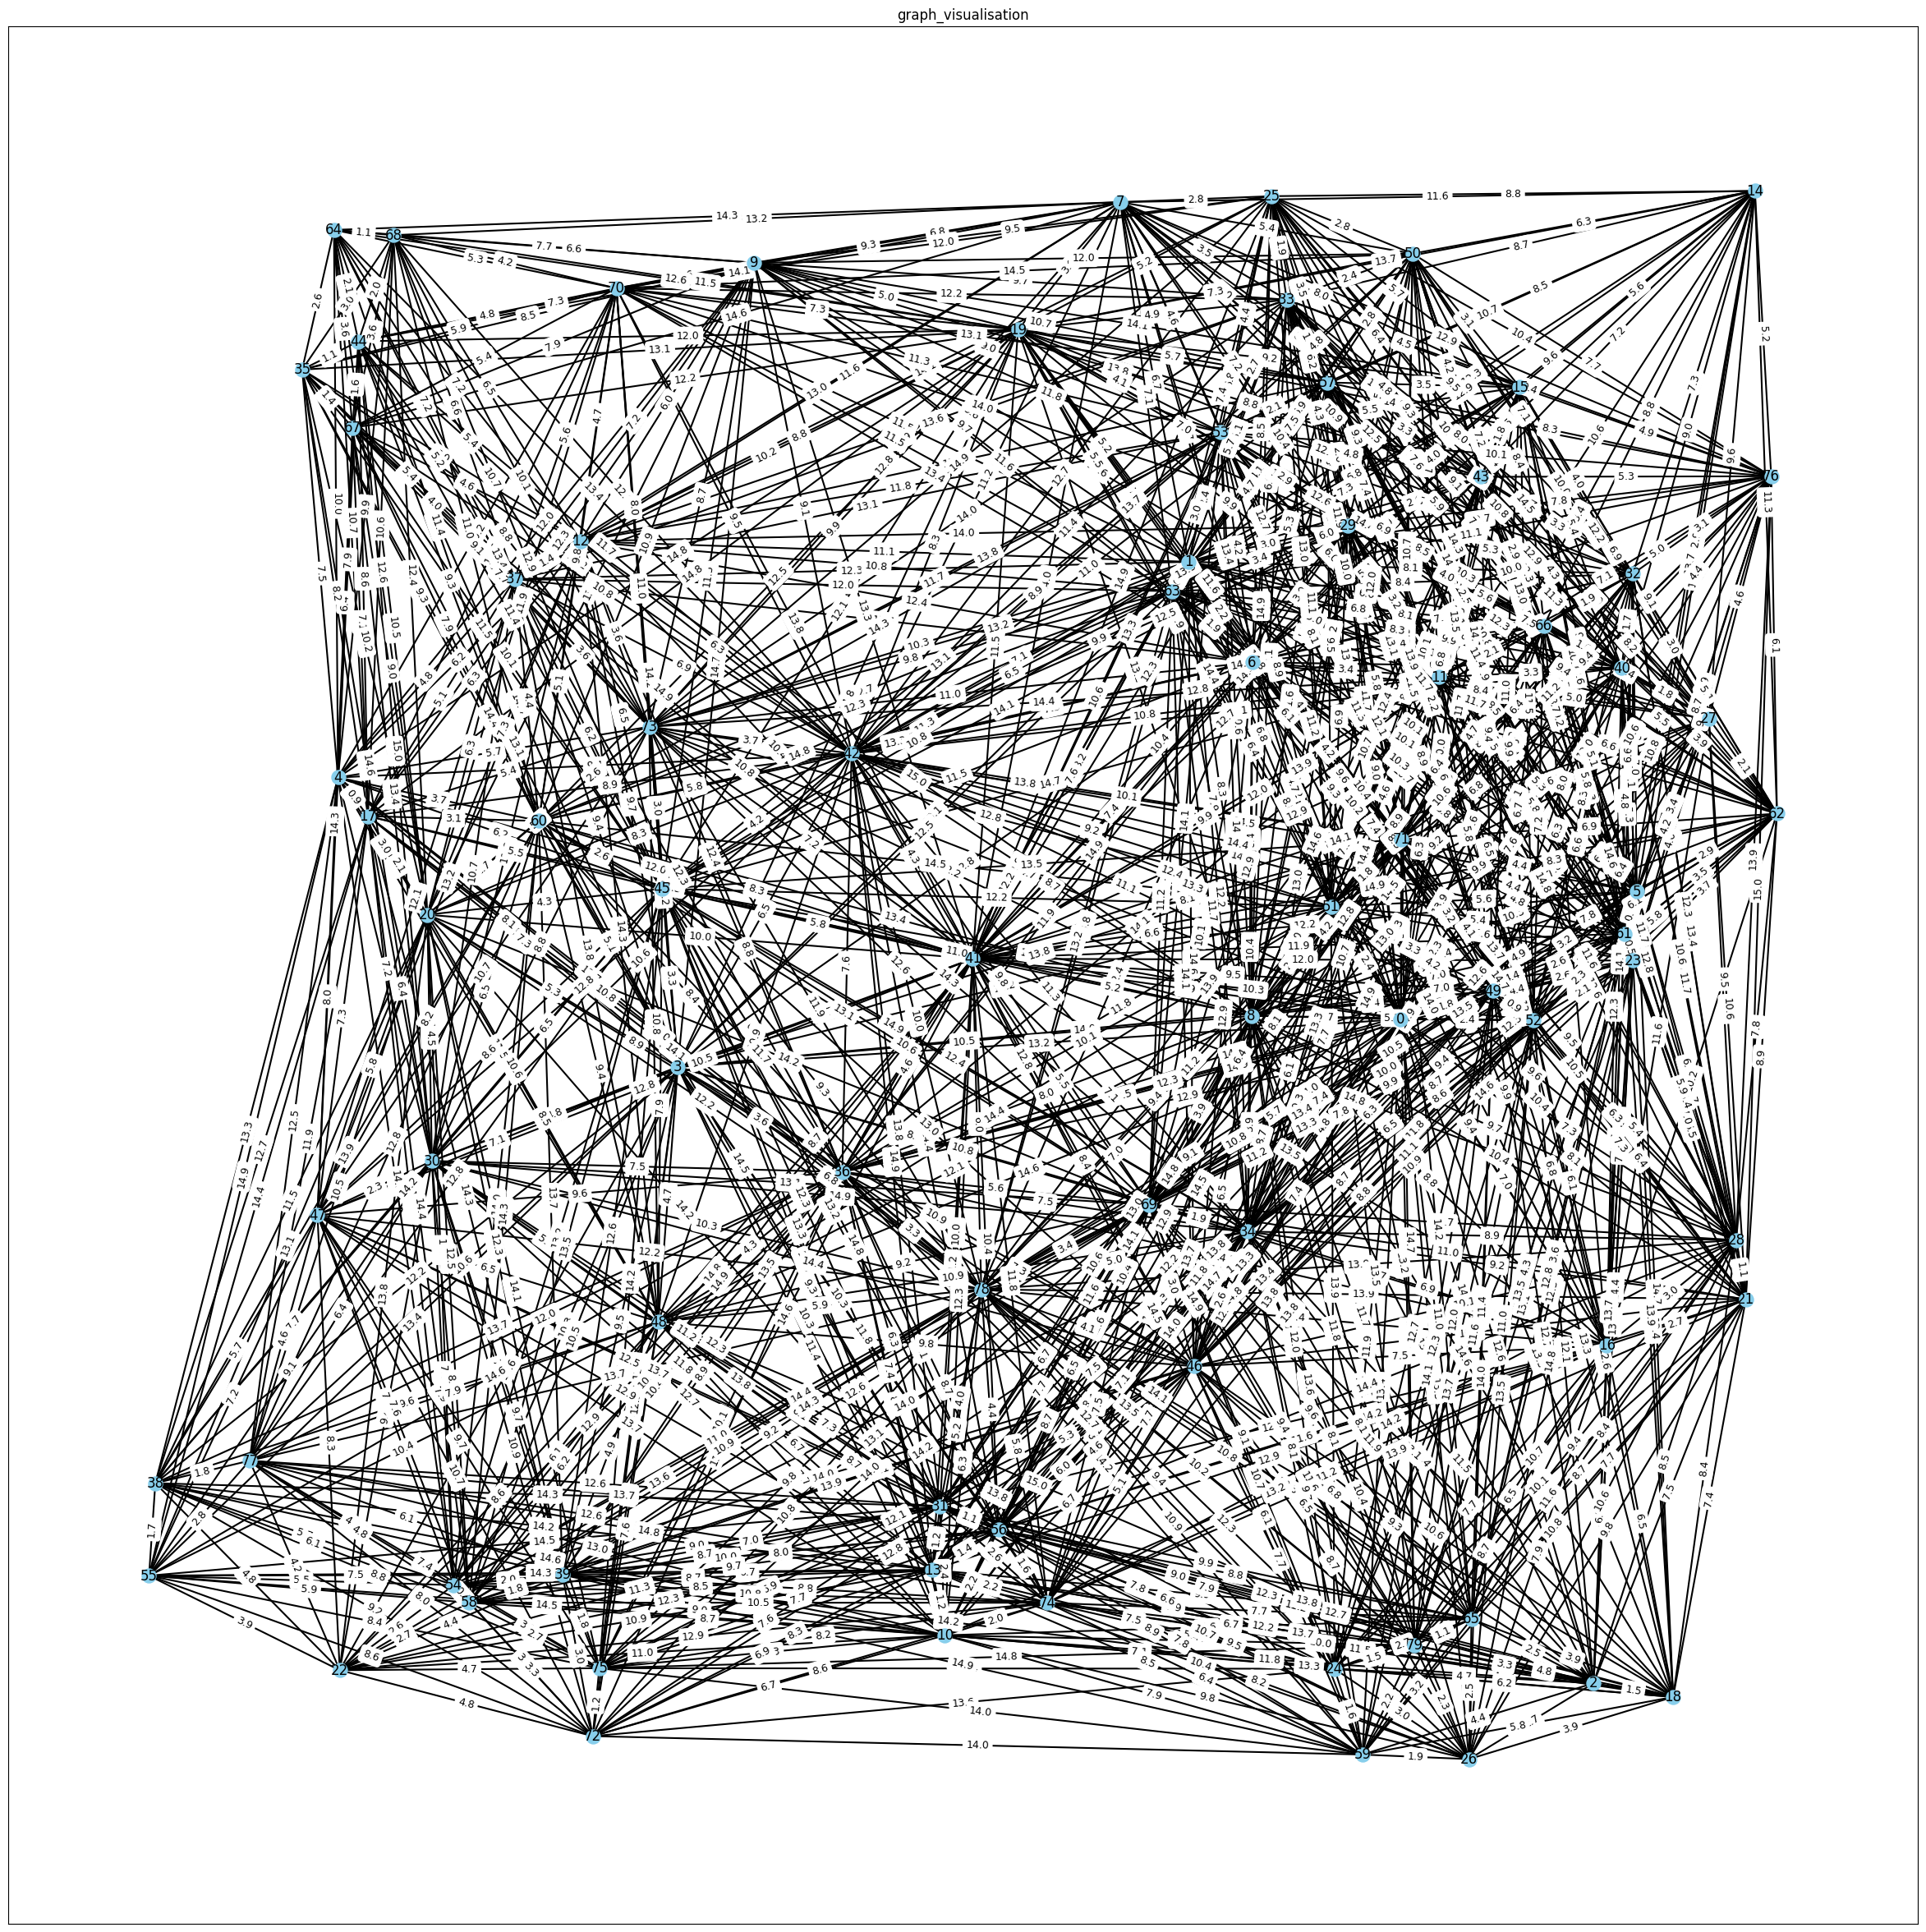

[ 0.28846662  0.62491125 -0.4971753  ...  0.58328139  0.29163128
  0.26641373]
[ 0.02234831 -0.11533739 -0.35754657 ... -0.05359712  0.33788956
  0.43030114]
[67, 66, 12, 17, 37, 20, 18, 16]
agents None
assignments = 
{67: [64, 35], 66: [29, 62, 53, 14, 71, 43, 40, 32, 50, 76, 63], 12: [7, 9, 70], 17: [73, 45, 4], 37: [42, 41], 20: [58, 47, 77, 55, 48, 72, 38, 75], 18: [26, 21, 24, 65, 79, 2], 16: [69, 34, 49, 0, 46, 78, 74, 8, 36, 52, 10, 31, 51, 56, 13]}
Agent 67 (Orders: 2): Route Len 3, route: [67, 35, 64], cost=4.00758844421664
Agent 67 (Orders: 2): Route Len 3, routewith tarffic: [67, 35, 64], cost with traffic =5.659092349687713
Agent 66 (Orders: 11): Route Len 12, route: [66, 40, 32, 76, 14, 50, 43, 29, 53, 63, 71, 62], cost=43.683752913292565
Agent 66 (Orders: 11): Route Len 12, routewith tarffic: [66, 71, 62, 76, 32, 40, 43, 29, 63, 53, 50, 14], cost with traffic =61.59057185095669
Agent 12 (Orders: 3): Route Len 4, route: [12, 70, 9, 7], cost=13.956512542329758
Agent 12 (Ord

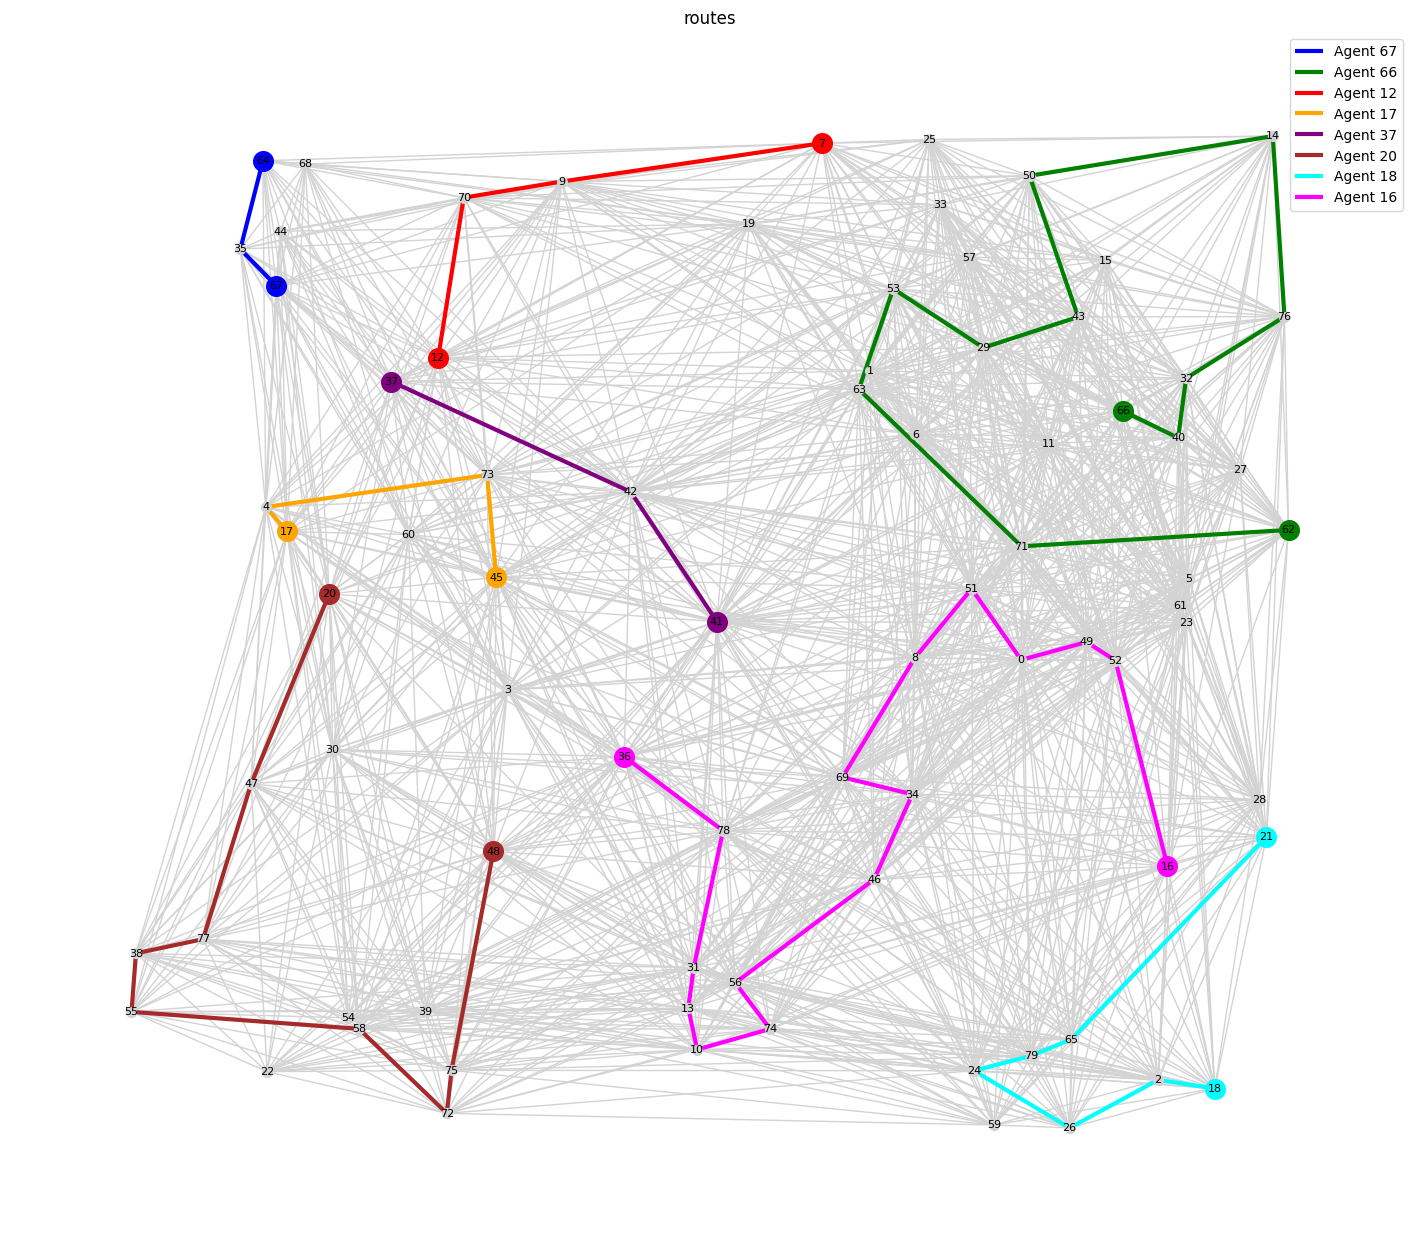

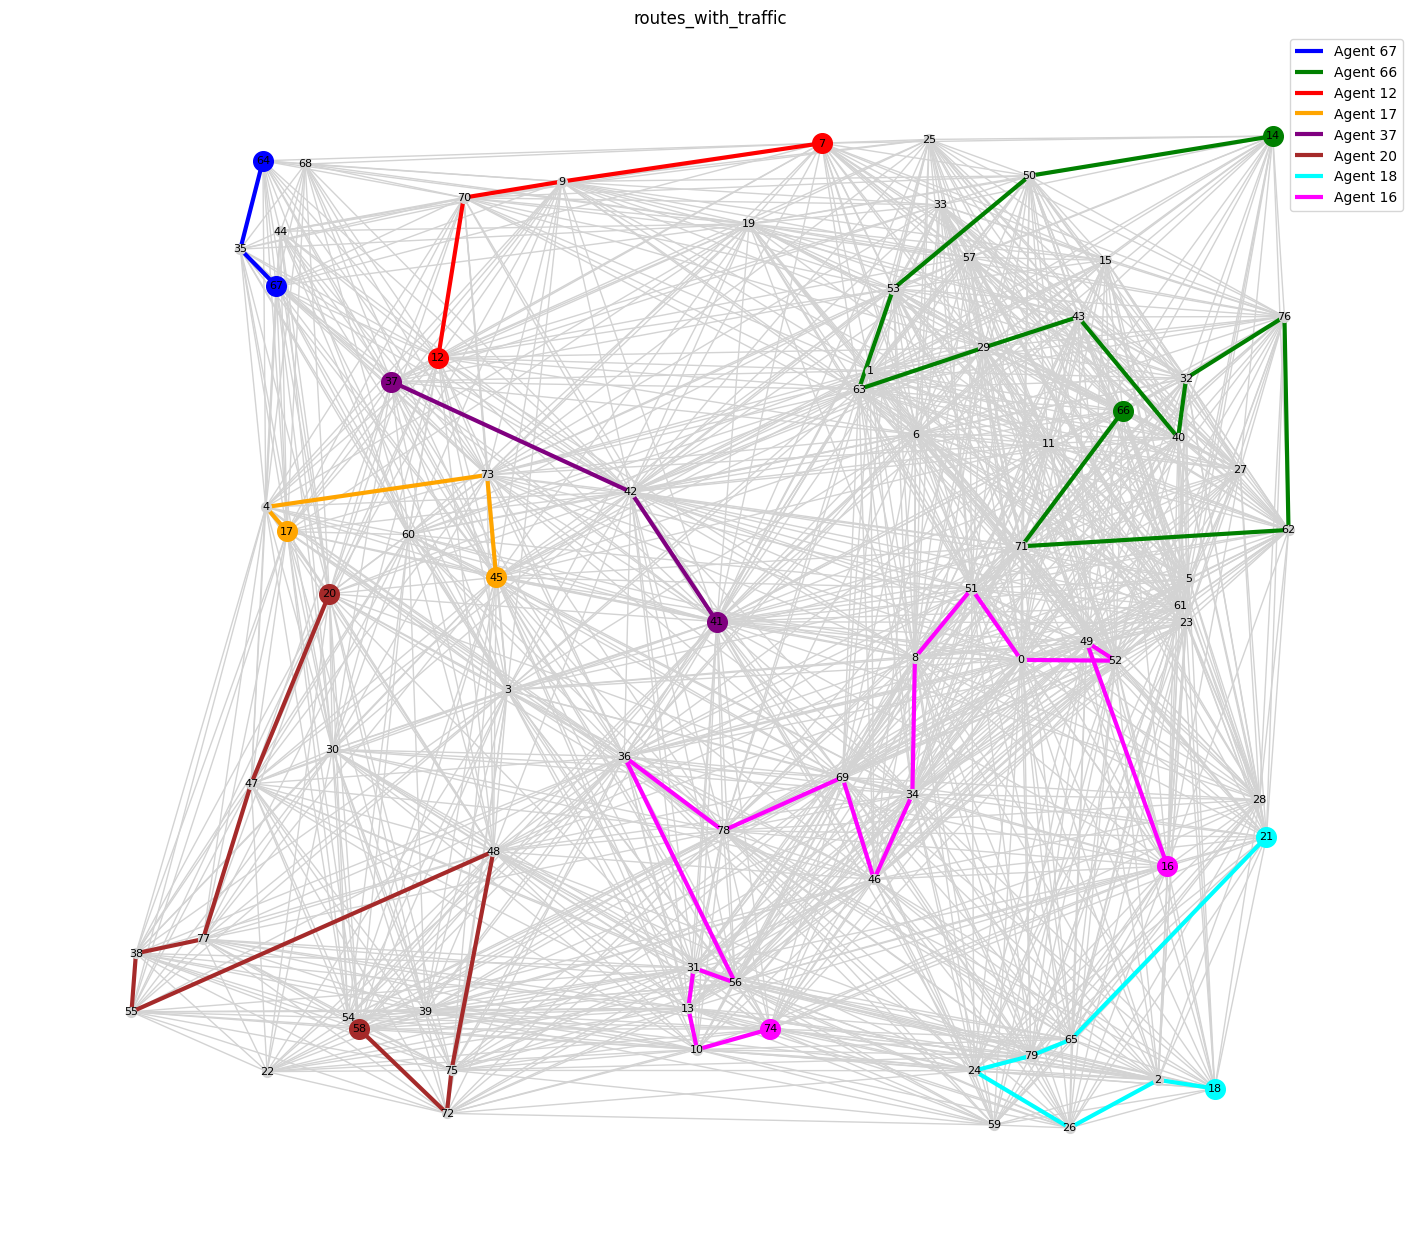

done
[60, 69, 52, 47, 77, 24, 70, 43]
agents None
assignments = 
{60: [17, 12, 4, 20, 73, 37], 69: [8, 46, 26, 65, 41], 52: [40, 5, 28, 21, 0, 62, 51, 23, 16, 61, 71, 49], 47: [30], 77: [58, 72, 38, 22, 55, 54, 39], 24: [31, 13, 56, 36, 74], 70: [68, 64, 35, 9], 43: [53, 33, 66, 63, 6, 32, 29, 11, 50, 57]}
Agent 60 (Orders: 6): Route Len 7, route: [60, 73, 12, 37, 4, 17, 20], cost=15.449124530440425
Agent 60 (Orders: 6): Route Len 7, routewith tarffic: [60, 20, 17, 4, 37, 12, 73], cost with traffic =22.889883783448315
Agent 69 (Orders: 5): Route Len 6, route: [69, 41, 8, 46, 65, 26], cost=26.539886036183656
Agent 69 (Orders: 5): Route Len 6, routewith tarffic: [69, 41, 8, 46, 65, 26], cost with traffic =36.16282244445338
Agent 52 (Orders: 12): Route Len 13, route: [52, 49, 0, 51, 71, 40, 62, 5, 61, 23, 28, 21, 16], cost=29.22176188315671
Agent 52 (Orders: 12): Route Len 13, routewith tarffic: [52, 49, 0, 51, 71, 40, 62, 5, 23, 61, 21, 28, 16], cost with traffic =44.5958676742665
Agent 

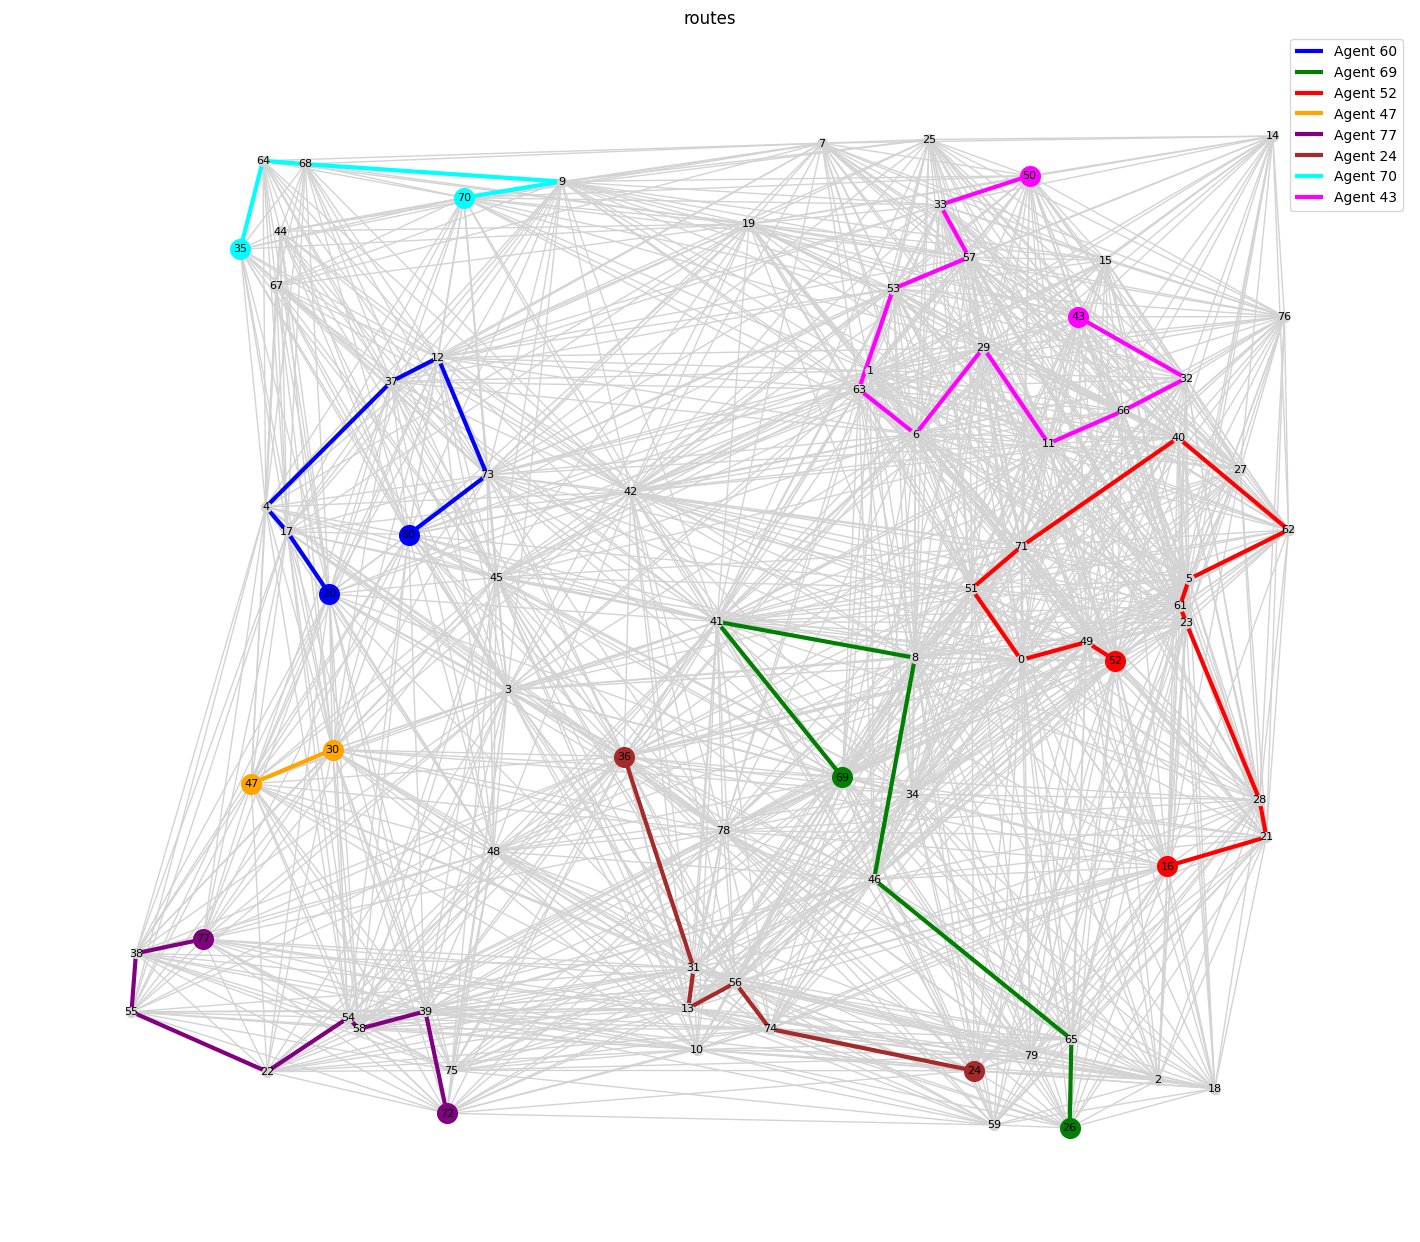

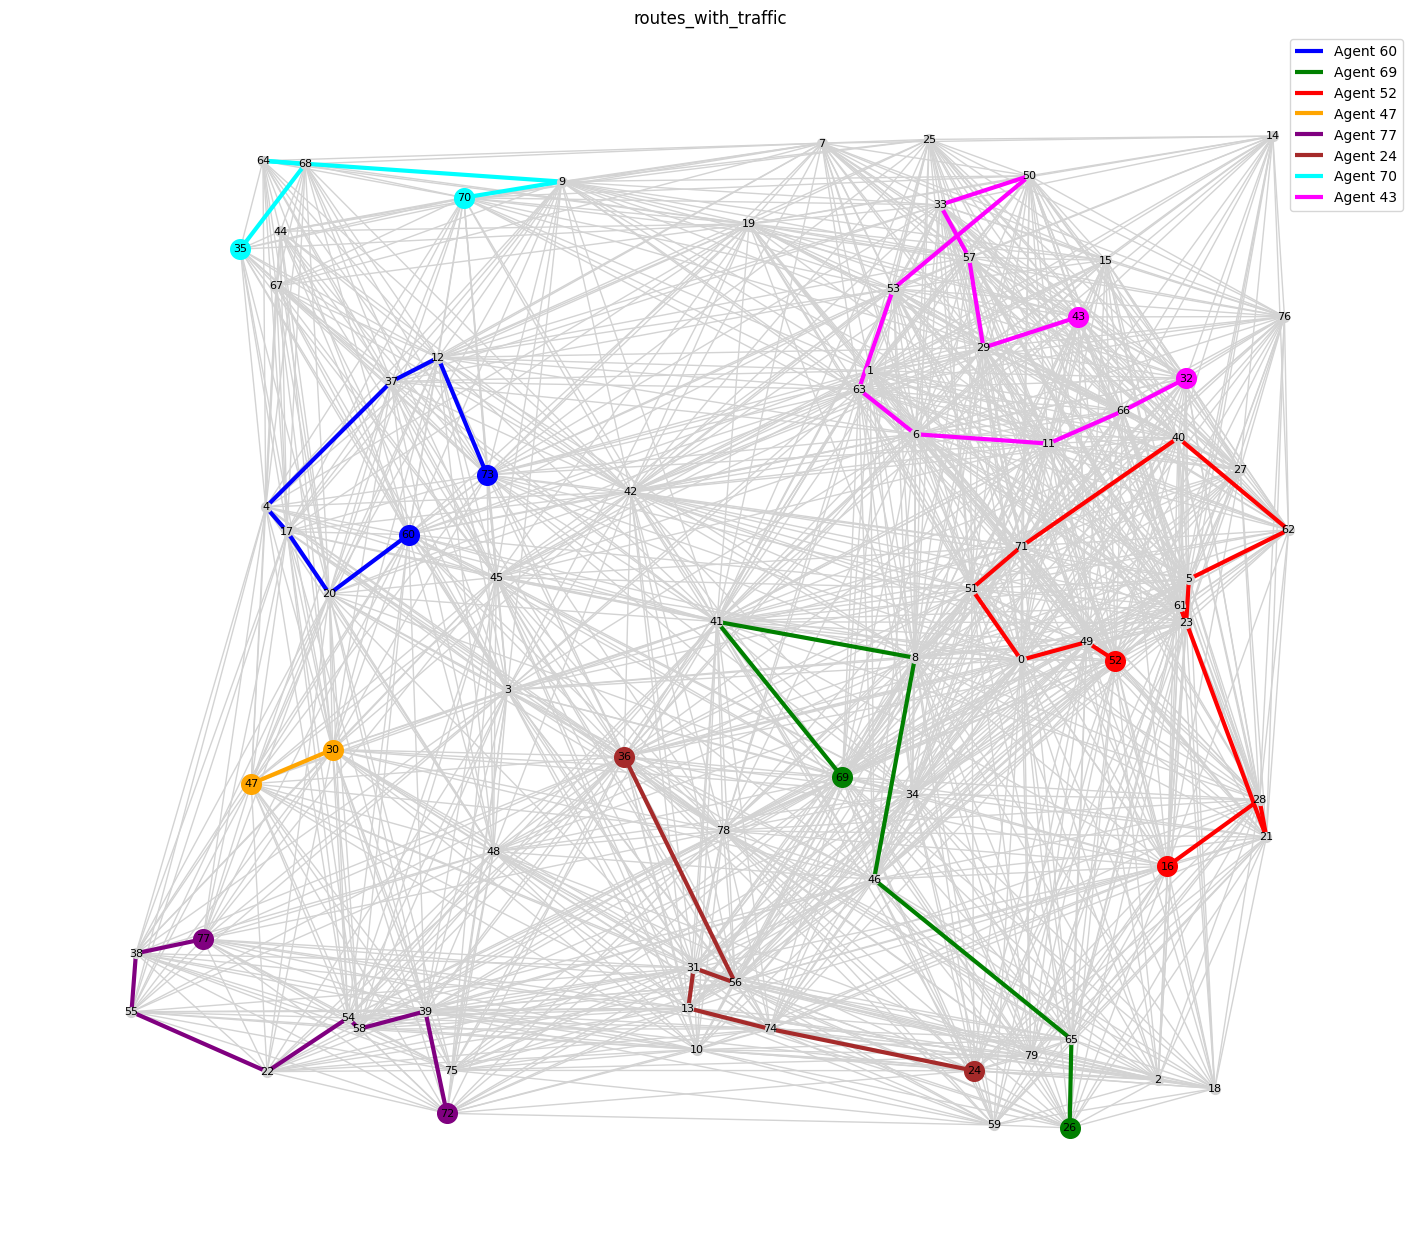

done
[(0, 1), (0, 2), (0, 3), (1, 2), (2, 3)]
[0, 1, 2, 3]
[-0.40877184 -0.02088276  0.20509109 -0.19632188  0.84824874]
[-0.316074   -0.13651019  0.22972324 -0.1793715   0.80503295]
{0: [1, 2, 3]}
Agent 0 (Orders: 3): Route Len 4, route: [0, 2, 1, 3], cost=10.0
Agent 0 (Orders: 3): Route Len 4, routewith tarffic: [0, 1, 2, 3], cost with traffic =10.341261649500646
Mean Squared Error (MSE): 0.12978
Mean Absolute Error (MAE): 0.28105
Correlation:0.79204
Sign matches: 1147 /1411 (81.3%)


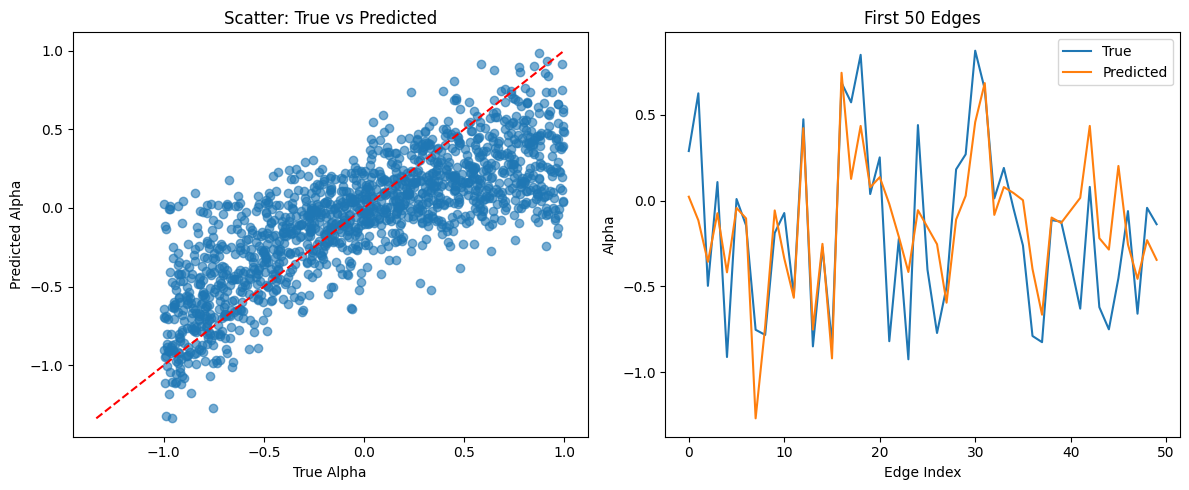

Mean Squared Error (MSE): 0.00494
Mean Absolute Error (MAE): 0.05862
Correlation:0.98797
Sign matches: 5 /5 (100.0%)


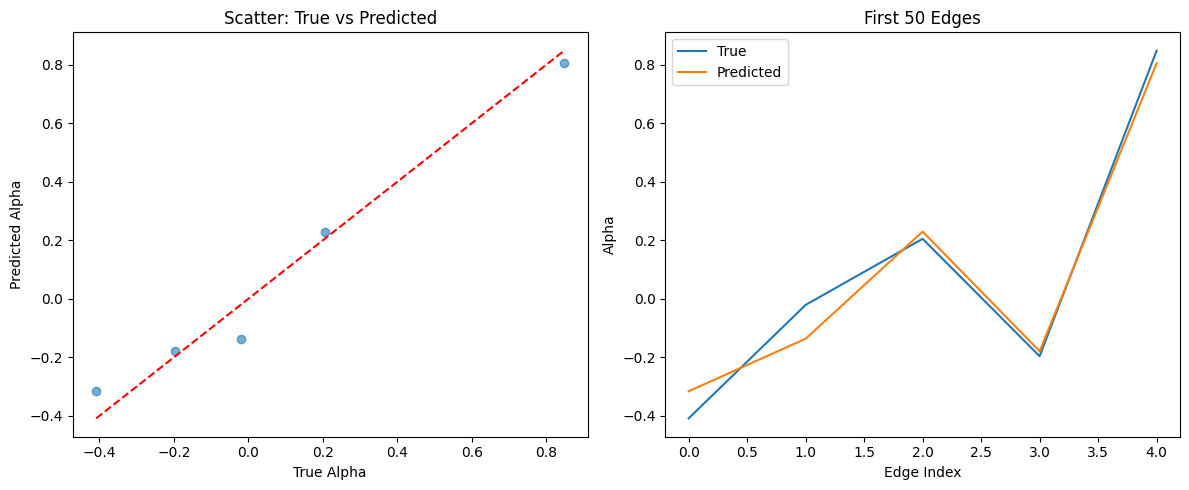

In [ ]:
if __name__ == "__main__":
    NUM_NODES = 80
    NUM_AGENTS = 8
    NUM_ORDERS = 50
    No_of_times=2
    city = City(NUM_NODES)
    city.visualize_graph()
    
    # print(len(city.G.edges()))
    
    
    training_data(city,2000,20)
    for _ in range(No_of_times):
        agent_routes = {}
        agent_routes_withtraffic = {}
        all_nodes=list(city.G.nodes())
        agent_starts = random.sample(all_nodes, NUM_AGENTS)
        print(f"agents {print(agent_starts)}")
        remaining_nodes= [n for n in all_nodes if n not in agent_starts]
        all_orders = random.sample(remaining_nodes, NUM_ORDERS)
        assignments = city.assign_orders_kmeans(agent_starts, all_orders)
        print(f"assignments = \n{assignments}")
        for agent_id, assigned_orders in assignments.items():
            if not assigned_orders:
                continue
            r,cost = city.route(agent_id, assigned_orders,False)
            agent_routes[agent_id] = r
            print(f"Agent {agent_id} (Orders: {len(assigned_orders)}): Route Len {len(r)}, route: {r}, cost={cost}")
            route,cost = city.route(agent_id, assigned_orders,True)
            agent_routes_withtraffic[agent_id]=route

            print(f"Agent {agent_id} (Orders: {len(assigned_orders)}): Route Len {len(route)}, routewith tarffic: {route}, cost with traffic ={cost*60}")
        city.visualize_all_routes(agent_routes,"routes")
        city.visualize_all_routes(agent_routes_withtraffic,"routes_with_traffic")
        print("done")
        locations2 = [0, 1, 2,3]
    locations_dict = {
    0: (0, 0),
    1: (-1, 0),
    2: (1, 0),
    3: (-6, 0)
    }
    edges = [
    (0, 1, 1.0),
    (0, 2, 1.0),
    (0, 3, 6.0),
    (1, 2, 2.0),
    (2, 3, 7.0)
]

    city2 = City(
    no_of_loc=len(locations2),
    locations=locations_dict,edges=edges)
    print((city2.G.edges()))
    print((city2.G.nodes()))
    training_data(city2,200,3)
    agent_starts=[0]
    all_orders=[1,2,3]
    assignments = city2.assign_orders_kmeans(agent_starts, all_orders)
    print(assignments)
    for agent_id, assigned_orders in assignments.items():
        r2,cost2 = city2.route(agent_id, assigned_orders,False)

        print(f"Agent {agent_id} (Orders: {len(assigned_orders)}): Route Len {len(r2)}, route: {r2}, cost={cost2}")
        rt2,costt2 = city2.route(agent_id, assigned_orders,True)
            # city.visualize_route(route)
        print(f"Agent {agent_id} (Orders: {len(assigned_orders)}): Route Len {len(rt2)}, routewith tarffic: {rt2}, cost with traffic ={costt2*60}")
    view_alpha(city)
    plot_alpha(city.true_alphas,city.learned_alphas)
    view_alpha(city2)
    plot_alpha(city2.true_alphas,city2.learned_alphas)


    # for _ in range(No_of_times):
    #     all_nodes=list(city.G.nodes())
    #     agent_starts = random.sample(all_nodes, NUM_AGENTS)
    #     # print("agents")
    #     # print(agent_starts)
    #     remaining_nodes= [n for n in all_nodes if n not in agent_starts]
    #     all_orders = random.sample(remaining_nodes, NUM_ORDERS)
    #     assignments = city.assign_orders_kmeans(agent_starts, all_orders)
    #     for agent_id, assigned_orders in assignments.items():
    #         if not assigned_orders:
    #             continue
    #         route,cost = city.route(agent_id, assigned_orders,False)
    #         # print(f"Agent {agent_id} (Orders: {len(assigned_orders)}): Route Len {len(route)}, route: {route}, cost={cost}")
    #         city.time_with_traffic(agent_id,route)

    #     # print("done")
    # print(city.true_alphas)
    # print(city.learned_alphas)
   